# **Importing Necessary Libraries**

In [1]:
import cv2
import shutil
import random, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2024-04-19 09:07:57.779624: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-19 09:07:57.779720: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-19 09:07:57.895081: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Some Configuration

In [2]:
df = pd.read_csv("../input/diabetic-retinopathy-224x224-gaussian-filtered/train.csv")

diagnosis_binary = {
        0: 'No_DR',
        1: 'DR',
        2: 'DR',
        3: 'DR',
        4: 'DR'}

diagnosis_classes = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df["binary"] = df["diagnosis"].map(diagnosis_binary.get)
df["type"] = df["diagnosis"].map(diagnosis_classes.get)

In [3]:
plt.figure(figsize = (8,8))

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

# **Data Visualization**

In [4]:
df.head()

id_code  diagnosis binary            type
0  000c1434d8d7          2     DR        Moderate
1  001639a390f0          4     DR  Proliferate_DR
2  0024cdab0c1e          1     DR            Mild
3  002c21358ce6          0  No_DR           No_DR
4  005b95c28852          0  No_DR           No_DR

<Axes: ylabel='type'>

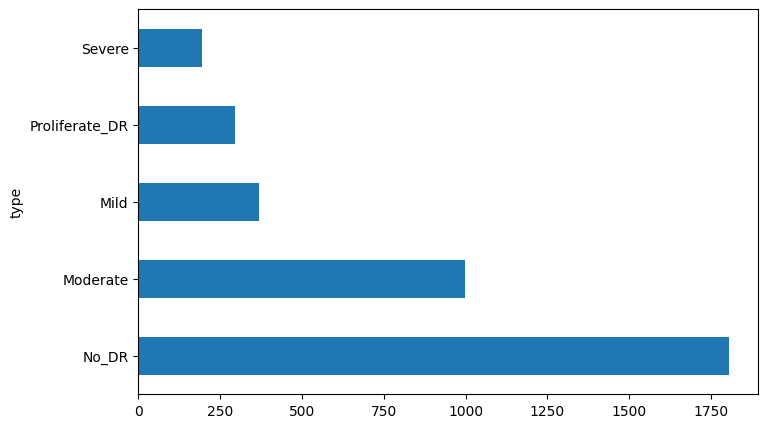

In [5]:
plt.figure(figsize = (8,5))
df['type'].value_counts().plot(kind='barh')

<Axes: ylabel='binary'>

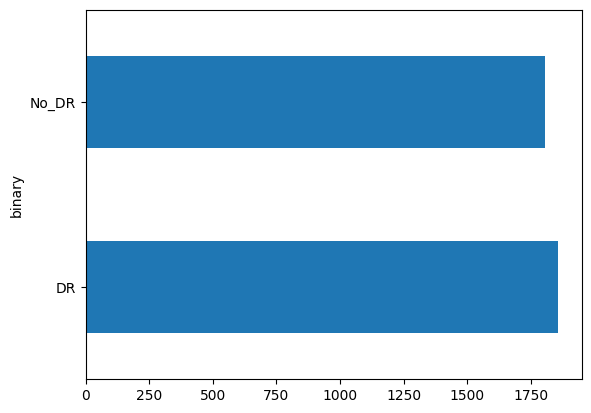

In [6]:
df['binary'].value_counts().plot(kind='barh')

In [7]:
df.columns

Index(['id_code', 'diagnosis', 'binary', 'type'], dtype='object')

In [8]:
df.head()

id_code  diagnosis binary            type
0  000c1434d8d7          2     DR        Moderate
1  001639a390f0          4     DR  Proliferate_DR
2  0024cdab0c1e          1     DR            Mild
3  002c21358ce6          0  No_DR           No_DR
4  005b95c28852          0  No_DR           No_DR

In [3]:
for column in df.columns:
    if column == "id_code":
        pass
    else:
        print(df[column].value_counts())

diagnosis
0    1805
2     999
1     370
4     295
3     193
Name: count, dtype: int64
binary
DR       1857
No_DR    1805
Name: count, dtype: int64
type
No_DR             1805
Moderate           999
Mild               370
Proliferate_DR     295
Severe             193
Name: count, dtype: int64


# **Data Preprocessing**

In [4]:
!pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25834 sha256=d7617e36401c86aab1a42fde698bb27eed45cae1ff61b702b877d3229cad1783
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


In [5]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelBinarizer
from imutils import paths
from sklearn.utils import shuffle

In [6]:
data = []
labels = []
width,height=224,224

imagePaths = list(paths.list_images('../input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images'))

data = []
labels = []

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]   
    image = load_img(imagePath, target_size=(width, height))
    image = img_to_array(image)
    data.append(image)
    labels.append(label)

data = np.array(data, dtype="float32")
labels = np.array(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)

data, labels = shuffle(data, labels)

print(data.shape)
print(labels.shape)

(3662, 224, 224, 3)
(3662, 5)


In [7]:
from imblearn.over_sampling import SMOTE

# Reshape the data into 2D format
data = data.reshape(data.shape[0], -1)

# Apply SMOTE to balance the classes
smote = SMOTE()
data_resampled, labels_resampled = smote.fit_resample(data, labels)

# Reshape the data back to its original shape
data_resampled = data_resampled.reshape(data_resampled.shape[0], width, height, 3)

# Shuffle the data
data_resampled, labels_resampled = shuffle(data_resampled, labels_resampled)

print(data_resampled.shape)
print(labels_resampled.shape)

(9025, 224, 224, 3)
(9025, 5)


In [8]:
# Normalization 
data_resampled = data_resampled / 255.0

# **Splitting Data to Training , Validatoin and Testing Sets**

In [9]:
x_train, x_test, y_train, y_test = train_test_split(data_resampled, labels_resampled, test_size=.2)

print("Train images:",x_train.shape)
print("Test images:",x_test.shape)
print("Train label:",y_train.shape)
print("Test label:",y_test.shape)

Train images: (7220, 224, 224, 3)
Test images: (1805, 224, 224, 3)
Train label: (7220, 5)
Test label: (1805, 5)


In [10]:
np.save('X_train.npy', x_train)
np.save('X_test.npy', x_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)

In [3]:
x_train = np.load('/kaggle/working/X_train.npy')
x_test = np.load('/kaggle/working/X_test.npy')
y_train = np.load('/kaggle/working/y_train.npy')
y_test = np.load('/kaggle/working/y_test.npy')

# Building the model

In [11]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization, Dropout
from keras.models import Model

## Fine-Tuning MobileNetV2

In [12]:
from tensorflow.keras.applications import MobileNetV2

mobile = MobileNetV2(input_shape=(224,224,3),weights='imagenet',include_top=False)

for layer in mobile.layers:
    layer.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [13]:
from tensorflow.keras.layers import Dense,Flatten,Input,Dropout,Activation,BatchNormalization,Lambda

x = Flatten()(mobile.output)
x = tf.keras.layers.Dense(128,activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
prediction = Dense(5,activation='softmax')(x)

model = Model(inputs=mobile.input, outputs=prediction)

#model.summary()#model.summary()


In [14]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

#Early Stopping

es = EarlyStopping(monitor='val_accuracy', min_delta = 0.01, patience=5, verbose=1, mode='auto')

#Model Check Point

mc = ModelCheckpoint(monitor='val_accuracy', filepath = '/kaggle/working/final_version_mobile.keras', verbose=1, save_best_only = True, mode='auto')

cd = [es,mc]

In [15]:
import tensorflow
adam = tensorflow.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(loss='binary_crossentropy',
              optimizer = adam,
              metrics=['accuracy']
)

In [16]:
history = model.fit(x=x_train,y=y_train,
          validation_data=(x_test,y_test),
          epochs=40,
          callbacks=cd,
          batch_size = 32,
          shuffle=True)

Epoch 1/40
  6/226 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.2092 - loss: 1.1327 

I0000 00:00:1713517932.965337     115 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4335 - loss: 0.5176
Epoch 1: val_accuracy improved from -inf to 0.67812, saving model to /kaggle/working/final_version_mobile.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 36s 102ms/step - accuracy: 0.4339 - loss: 0.5171 - val_accuracy: 0.6781 - val_loss: 0.3001
Epoch 2/40
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6701 - loss: 0.3103
Epoch 2: val_accuracy improved from 0.67812 to 0.74072, saving model to /kaggle/working/final_version_mobile.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.6701 - loss: 0.3102 - val_accuracy: 0.7407 - val_loss: 0.2579
Epoch 3/40
224/226 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7398 - loss: 0.2637
Epoch 3: val_accuracy improved from 0.74072 to 0.77064, saving model to /kaggle/working/final_version_mobile.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.7398 - loss: 0.2637 - val_accuracy: 0.7706 - val_loss: 0.2279
Epoch 4/40
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

# Plot the Curves

<Figure size 800x800 with 0 Axes>

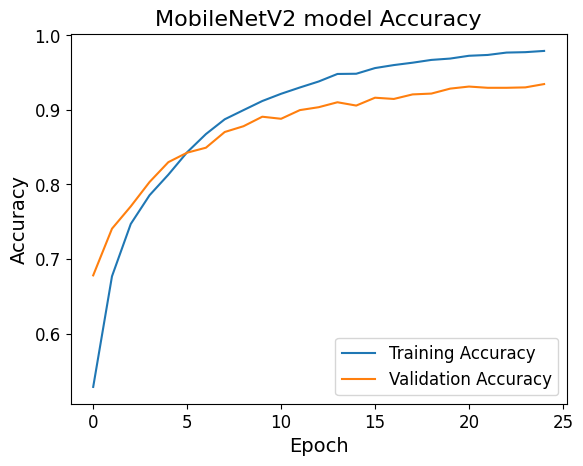

In [17]:
# Plot accuracy curve
plt.figure(figsize=(8,8))
history = history
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'], label='Training Accuracy')
ax.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax.set_title('MobileNetV2 model Accuracy', fontsize=16)
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.legend(loc='lower right', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
plt.show()

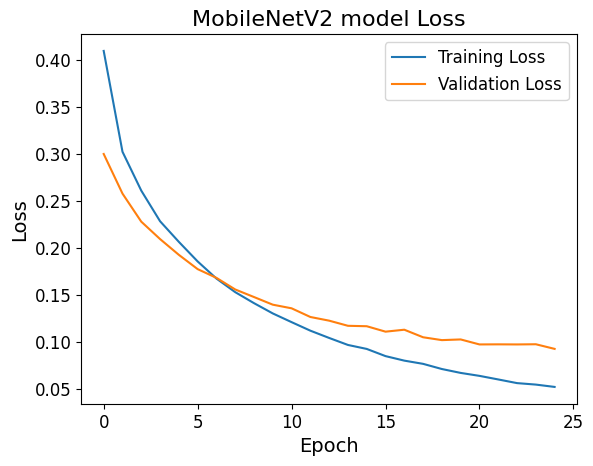

In [18]:
# Plot loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('MobileNetV2 model Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.tick_params(axis='both', labelsize=12)
plt.show()

# Evaluating the model

In [5]:
from tensorflow.keras.models import load_model

model = load_model("/kaggle/working/final_version.keras")

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 734 variables whereas the saved optimizer has 26 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [19]:
loss, score = model.evaluate(x_test,y_test)

print("model loss: ", loss)
print("model accuracy: ", score*100)

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9440 - loss: 0.0812
model loss:  0.09242603927850723
model accuracy:  93.4626042842865


In [20]:
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step


In [21]:
# Step-1 (the Prediction step)

# Predicting the Test set results
HH_Ann_model_y_pred = model.predict(x_test) 

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


In [22]:
# Some Information about the variable
HH_Ann_model_y_pred[0], type(HH_Ann_model_y_pred), HH_Ann_model_y_pred.ndim

(array([9.4149470e-07, 1.0987813e-05, 9.9996769e-01, 1.6873125e-06,
        1.8768365e-05], dtype=float32),
 numpy.ndarray,
 2)

In [23]:
# Step-2 Converting the Results into a DataFrame shape
HH_pred_df = pd.DataFrame(HH_Ann_model_y_pred)

HH_pred_df.head(), HH_pred_df.shape

(              0             1             2             3             4
 0  9.414947e-07  1.098781e-05  9.999677e-01  1.687313e-06  1.876837e-05
 1  1.091521e-08  1.254752e-06  2.062284e-08  1.944388e-07  9.999986e-01
 2  1.087414e-12  5.722080e-13  1.000000e+00  1.002534e-12  1.199766e-12
 3  3.024208e-04  9.961942e-01  1.508361e-04  2.653034e-03  6.995226e-04
 4  6.030624e-05  2.235088e-03  2.937109e-04  9.972724e-01  1.385335e-04,
 (1805, 5))

In [24]:
# Step-3 Converting the labels of the DataFrame of the Step-2

# Define a function to modify the values in each row
def modify_row(row):
    # Calculate the largest number in the current row
    max_value = row.max()

    # Replace the largest number in the current row with 1 and the rest with 0
    row[row != max_value] = 0
    row[row == max_value] = 1

    # Return the modified row
    return row

# Apply the modify_row function to each row of the DataFrame
HH_labels = HH_pred_df.apply(modify_row, axis=1)

In [25]:
HH_labels.head(), HH_labels.shape

(     0    1    2    3    4
 0  0.0  0.0  1.0  0.0  0.0
 1  0.0  0.0  0.0  0.0  1.0
 2  0.0  0.0  1.0  0.0  0.0
 3  0.0  1.0  0.0  0.0  0.0
 4  0.0  0.0  0.0  1.0  0.0,
 (1805, 5))

In [26]:
# Step-5 converting the predicted labels to numpy array

# The converstion
labels_arr = HH_labels.to_numpy()
labels_arr

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [27]:
# Step-6 collect the DataFrame(actual labels, predictied labels)

# Define the class names
classes = diagnosis_classes

# Convert the arrays to a single column
Y_test_col = y_test.argmax(axis=1)
labels_col = labels_arr.argmax(axis=1)

# Replace the values with their corresponding keys
Y_test_col = pd.Series(Y_test_col).map(classes)
labels_col = pd.Series(labels_col).map(classes)

# Create a new dataframe
df = pd.DataFrame({'True Label': Y_test_col, 'Predicted Label': labels_col})

In [28]:
df.head()

True Label Predicted Label
0        Moderate        Moderate
1  Proliferate_DR  Proliferate_DR
2        Moderate        Moderate
3            Mild            Mild
4          Severe          Severe

Accuracy Score: 0.9346260387811635
Precision Score: 0.9351828567383984
Recall Score: 0.9346260387811635
F1 Score: 0.9336137736105975
Sensitivity: 0.9911242603550295
Specificity: [0.9827705  0.99650594 0.9972028  1.        ]
PPV: 0.907859078590786
NPV: 0.9979006298110566


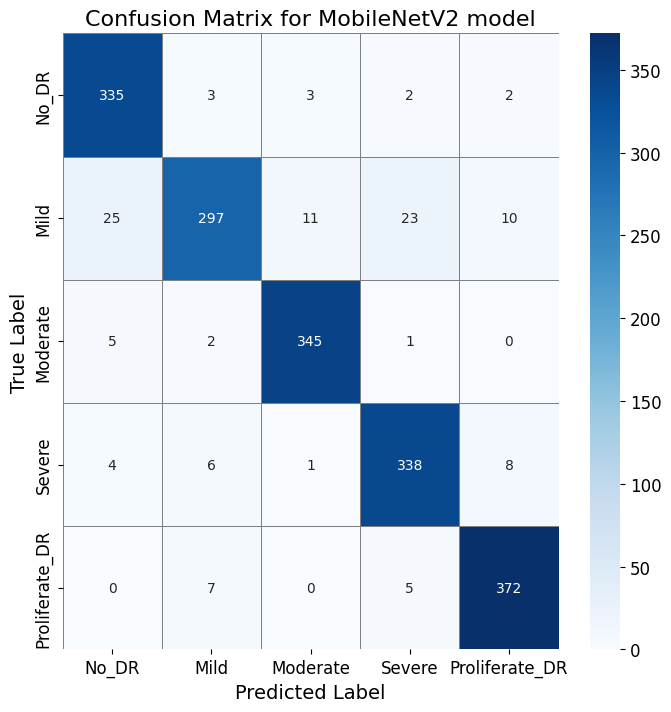

In [29]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# Step-7 compute the Measurements for the model

# Create the Confusion Matrix out of the Actual and Predicted Data
cm = confusion_matrix(df["True Label"], df["Predicted Label"], labels=list(classes.values()))

# Calculate the accuracy score
accuracy = accuracy_score(df["True Label"], df["Predicted Label"])

# Calculate the precision score
precision = precision_score(df["True Label"], df["Predicted Label"], average='weighted')

# Calculate the recall score
recall = recall_score(df["True Label"], df["Predicted Label"], average='weighted')

# Calculate the F1 score
f1 = f1_score(df["True Label"], df["Predicted Label"], average='weighted')

# Calculate the sensitivity and specificity
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1:, 1:].sum() / (cm[1:, 0] + cm[1:, 1:].sum())

# Calculate the PPV and NPV
ppv = cm[0, 0] / (cm[0, 0] + cm[1:, 0].sum())
npv = cm[1:, 1:].sum() / (cm[0, 1] + cm[1:, 1:].sum())

# Print the evaluation metrics
print('Accuracy Score:', accuracy)
print('Precision Score:', precision)
print('Recall Score:', recall)
print('F1 Score:', f1)
print('Sensitivity:', sensitivity)
print('Specificity:', specificity)
print('PPV:', ppv)
print('NPV:', npv)

# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(8, 8))

# Generate the heatmap with Seaborn
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=list(classes.values()), yticklabels=list(classes.values()), ax=ax, linewidths=0.5, linecolor='gray')

# Set the axis labels and title
ax.set_xlabel('Predicted Label', fontsize=14)
ax.set_ylabel('True Label', fontsize=14)
ax.set_title('Confusion Matrix for MobileNetV2 model', fontsize=16)

# Set the colorbar properties
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)

# Set the tick labels' font size
ax.tick_params(axis='both', labelsize=12)

# Display the figure
plt.show()

In [30]:
from sklearn.metrics import cohen_kappa_score

# Calculate the kappa score
kappa = cohen_kappa_score(df["True Label"], df["Predicted Label"])

print("Kappa Score for the VGG16 model:", kappa)

Kappa Score for the VGG16 model: 0.9182721695229902


In [31]:
# Generate classification report
from sklearn.metrics import classification_report

report_HH = classification_report(df["True Label"], df["Predicted Label"])

print(report_HH);

                precision    recall  f1-score   support

          Mild       0.94      0.81      0.87       366
      Moderate       0.96      0.98      0.97       353
         No_DR       0.91      0.97      0.94       345
Proliferate_DR       0.95      0.97      0.96       384
        Severe       0.92      0.95      0.93       357

      accuracy                           0.93      1805
     macro avg       0.93      0.94      0.93      1805
  weighted avg       0.94      0.93      0.93      1805



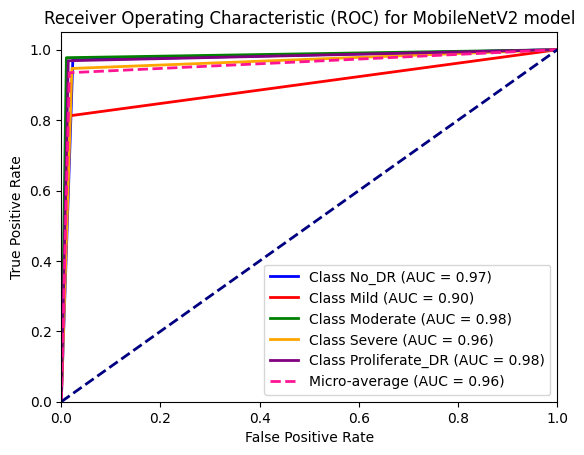

In [32]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Binarize the true labels and predicted labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
y_pred_bin = label_binarize(HH_Ann_model_y_pred, classes=[0, 1, 2, 3, 4])

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_bin.shape[1]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_bin.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure()
colors = ['blue', 'red', 'green', 'orange', 'purple']  # Modify colors as needed
classes = diagnosis_classes
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='Class {0} (AUC = {1:0.2f})'.format(classes[i], roc_auc[i]))

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle='--', lw=2,
         label='Micro-average (AUC = {0:0.2f})'.format(roc_auc["micro"]))


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for MobileNetV2 model')
plt.legend(loc="lower right")
plt.show()

# ***Visualizing a prediction***

[0 0 0 1 0]
Prediction: Proliferate_DR


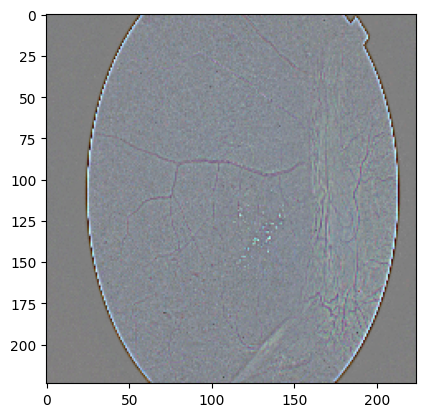

In [33]:
index =5
predictions=["Mild","Moderate","NO_DR","Proliferate_DR","Severe"] 

img = x_test[index]
RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
RGBImg= cv2.resize(RGBImg,(224,224))

plt.imshow(RGBImg)
print(y_test[index]) # true
print(f"Prediction: {predictions[pred[index]]}") # predicted  

# **Predicting a new Sample**

In [34]:
import cv2

def predict_new(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0

    predict=model.predict(np.array([image]))
    pred=np.argmax(predict,axis=1)
    
    print(f"Predicted: {predictions[pred[0]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted: Mild


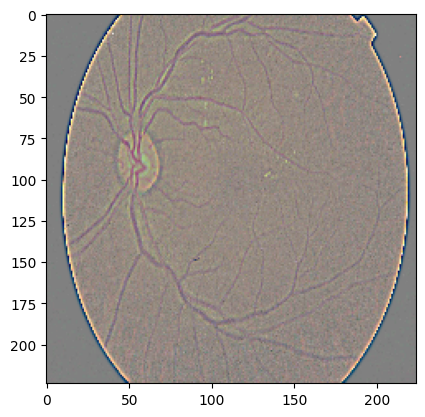

In [35]:
predict_new("../input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Mild/01b3aed3ed4c.png")
#True --> Mild